# XGBoost

## Load and import data

In [28]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.decomposition import TruncatedSVD
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import accuracy_score,precision_score, recall_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score
from src.data.make_dataset import main as get_data
import scipy
import matplotlib.pyplot as plt
import pickle

In [2]:
X_train, X_test, y_train, y_test = get_data("../../data/raw/reviews.csv")

[FE] finished pos tag count...
[FE] finished tokenized_untokenized count...
[FE] finished pos neg count...


## Prepare data for XGB

In [4]:
X_train.drop(["uppercase_words"], axis=1, inplace=True)
X_test.drop(["uppercase_words"], axis=1, inplace=True)

In [5]:
vectorizer = TfidfVectorizer()

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

X_train_tfidf = vectorizer.fit_transform(X_train['cleaned_text'])
X_test_tfidf = vectorizer.transform(X_test['cleaned_text'])

X_train_tfidf = pd.DataFrame(X_train_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
X_test_tfidf = pd.DataFrame(X_test_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

X_train_clean = X_train.drop(['cleaned_text', 'text'], axis=1)
X_test_clean = X_test.drop(['cleaned_text', 'text'], axis=1)

X_train_concat = pd.concat([X_train_clean, X_train_tfidf], axis=1)
X_test_concat = pd.concat([X_test_clean, X_test_tfidf], axis=1)

X_train_concat = X_train_concat.loc[:, ~X_train_concat.columns.duplicated()].copy()
X_test_concat = X_test_concat.loc[:, ~X_test_concat.columns.duplicated()].copy()

/Users/usman_s/mambaforge/envs/data-dialogue/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

## Vanilla XGBoost

In [ ]:
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_clf.fit(X_train_concat, y_train)

### Evaluation

In [6]:
# Make predictions on the testing set
y_pred = xgb_clf.predict(X_test_concat)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("f1-score:", f1_score)
print("Confusion Matrix: \n", conf_matrix)
print("Classification Report: \n", class_report)

Accuracy: 0.8870523415977961
Precision: 0.910950661853189
Recall: 0.9392059553349876
f1-score: 0.9248625534514355
Confusion Matrix: 
 [[209  74]
 [ 49 757]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.74      0.77       283
           1       0.91      0.94      0.92       806

    accuracy                           0.89      1089
   macro avg       0.86      0.84      0.85      1089
weighted avg       0.88      0.89      0.89      1089



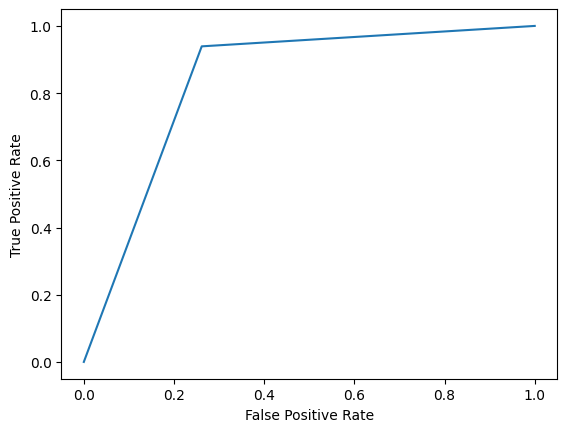

For this XGBoost model, the AUC score is: 0.8388609281975291


In [7]:
# plot roc curve
fpr, tpr, _ = roc_curve(y_test,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
auc = roc_auc_score(y_test, y_pred)
print(f"For this XGBoost model, the AUC score is: {auc}")

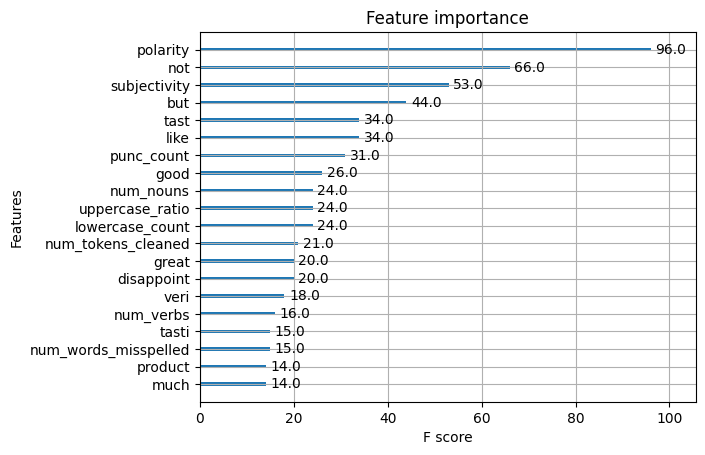

In [8]:
# feature selection
plot_importance(xgb_clf, max_num_features=20)
plt.show()

## XGBoost with dimensionality reduction and Tuning

### SVD

In [10]:
n_components = 100
svd = TruncatedSVD(n_components=n_components)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

In [11]:
X_train_svd_df = pd.DataFrame(X_train_svd, columns=[f'svd_{i}' for i in range(n_components)])
X_test_svd_df = pd.DataFrame(X_test_svd, columns=[f'svd_{i}' for i in range(n_components)])

X_train_concat_svd = pd.concat([X_train_clean, X_train_svd_df], axis=1)
X_test_concat_svd = pd.concat([X_test_clean, X_test_svd_df], axis=1)

### Tuning and fitting (Do not run again)

In [18]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
    'n_estimators': [100, 200, 500],
}

In [19]:
xgb_clf_tuned = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

/Users/usman_s/mambaforge/envs/data-dialogue/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [29]:
grid_search = GridSearchCV(estimator=xgb_clf_tuned, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [35]:
grid_search.fit(X_train_svd, y_train)

/Users/usman_s/mambaforge/envs/data-dialogue/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/usman_s/mambaforge/envs/data-dialogue/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.7, 1],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5, 6],
                         'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 200, 500],
                         'subsample': [0.5, 0.7, 1]},
             scoring='accuracy')

In [37]:
best_params = grid_search.best_params_ 
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best accuracy score:", best_score)

Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.5}
Best accuracy score: 0.8652123995407578


In [38]:
xgb_best_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', **best_params)
xgb_best_clf.fit(X_train_svd, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

### Evaluation

In [39]:
y_pred_tuned = xgb_best_clf.predict(X_test_svd)
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test,y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)
conf_matrix_tuned = confusion_matrix(y_test, y_pred_tuned)
class_report_tuned = classification_report(y_test, y_pred_tuned)
f1_score_tuned = f1_score(y_test, y_pred_tuned)


print("Accuracy on the test set:", accuracy)
print("Precision:", precision_tuned)
print("Recall:", recall_tuned)
print("f1-score:", f1_score_tuned)
print("Confusion Matrix: \n", conf_matrix_tuned)
print("Classification Report: \n", class_report_tuned)

Accuracy on the test set: 0.8870523415977961
Precision: 0.8781065088757396
Recall: 0.9205955334987593
f1-score: 0.8988491823137492
Confusion Matrix: 
 [[180 103]
 [ 64 742]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.74      0.64      0.68       283
           1       0.88      0.92      0.90       806

    accuracy                           0.85      1089
   macro avg       0.81      0.78      0.79      1089
weighted avg       0.84      0.85      0.84      1089



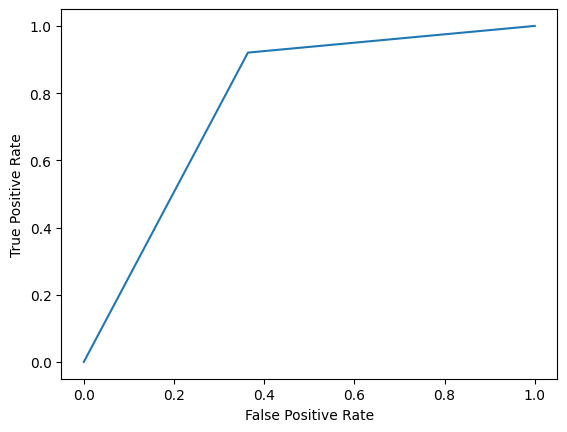

For this XGBoost model, the AUC score is: 0.7783189681628073


In [40]:
# plot roc curve
fpr, tpr, _ = roc_curve(y_test,  y_pred_tuned)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
auc = roc_auc_score(y_test, y_pred_tuned)
print(f"For this XGBoost model, the AUC score is: {auc}")

## Store both tuned and vanilla models and vectorizers

In [41]:
# vanilla model
with open("xgb_original_model.pkl", "wb") as f:
    pickle.dump(xgb_clf, f)

In [42]:
# tuned model with SVD
with open("xgb_tuned_model_svd.pkl", "wb") as f:
    pickle.dump(xgb_best_clf, f)

In [43]:
# Save the TF-IDF Vectorizer to a file
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

In [44]:
# Save the Truncated SVD instance to a file
with open("truncated_svd.pkl", "wb") as f:
    pickle.dump(svd, f)